In [1]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import fokker_planck

# Introduction and algorithm

This example notebook shows how to use the fokker_planck module to **parametrize the drift $a(x)$ and diffusivity $D(x)$** of the **Fokker-Planck equation**

\begin{align}
\partial_t P (x,t|x_0,t_0) &= - \partial_x \left[ a(x) P(x,t|x_0,t_0)\right] + \partial_x^2 \left[ D(x) P(x,t|x_0,t_0)\right]
\end{align}

on a domain $[x_L, x_R]$. In the above equation, $P(x,t|x_0,t_0)$ is the Fokker-Planck propagator. We assume that $a(x)$, $D(x)$ are time-independent.

More specifically,
we assume we are **given a list of sample trajectories** of the **Ito-Langevin equation** corresponding to the above Fokker-Planck equation, i.e. sample realizations of
\begin{equation}
dX_t = a(X_t)dt + \sqrt{2D(X_t)}dW_t,
\end{equation}
where $dW_t$ is the increment of the Wiener process and we interpret the equation using the Ito convention for the stochastic integral. The sample trajectories all have the same timestep $\Delta t$ and cover the domain $[x_L, x_R]$ (what this means is discussed further below under limitations).

Based on this data, we infer the drift and diffusivity using the first two **Kramers-Moyal coefficients**

\begin{align}
a(x) &= \lim_{\Delta t \rightarrow 0} \frac{\left.\langle X_{\Delta t} - X_0 \rangle\right|_{X_0 = x} }{\Delta t},
\\
D(x) &= \lim_{\Delta t \rightarrow 0} \frac{\left.\langle (X_{\Delta t} - X_0)^2 \rangle\right|_{X_0 = x} }{ 2\Delta t},
\end{align}

where the averages are ensemble averages over all Langevin realization that start at $X_0 \equiv x$.


The **algorithm** works as follows. First, the domain $[x_L, x_R]$ is partitioned into $N_{\mathrm{bins}}$ bins with centers $x_i$, $i \in \{1,...,N_{\mathrm{bins}}\}$, and widths $\Delta x$.
Then, for each bin center $x_i$ we use the sample trajectories to **estimate drift and diffusivity** via

\begin{align}
a(x_i) &=  \frac{\langle X_{\Delta t^*} - X_0 \rangle }{\Delta t^*},\\
D(x_i) &= \frac{\langle (X_{\Delta t^*} - X_0)^2 \rangle }{ 2\Delta t^*},
\end{align}

where $\Delta t^* = N_{\mathrm{shift}} \cdot \Delta t$ is a multiple of the timestep of the data, and for the bin centered at $x_i$ the averages $\langle \bullet \rangle$ are averages using all pairs $( X_{t+ \Delta t^*},  X_{t})$ from all sample trajectories such that $X_t$ is in the bin $[x_i - \Delta x/2, x_i + \Delta x/2]$.

From these formulas the **limitations** of this method are apparent:
* *Amount of data needed.* The trajectorial data, the spatial domain $[x_L,x_R]$ and the number of bins $N_{\mathrm{bins}}$ (or equivalently the bin width $\Delta x$) need to be such that within each bin, there are enough trajectorial samples to obtain a reliable average.
* *Timestep $\Delta t$ and lagtime $\Delta t^*$.* Since the definition of the Kramers-Moyal coefficients contains a limit $\Delta t \rightarrow 0$, the lagtime $\Delta t^* \equiv N_{\mathrm{shift}} \cdot \Delta t$ needs to be small enough so that the limit is effectively reached. This means that both the timestep $\Delta t$ and the integer $N_{\mathrm{shift}}$ need to be small. 

Note that if there are measurement errors of the order of the bin width $\Delta x$, it might not be desirable to use $N_{\mathrm{shift}} = 1$, but a slightly larger value. Practically, one should calculate the Kramers-Moyal coefficients for several values of $N_{\mathrm{shift}}$, and check that the results are (approximately) independent of $N_{\mathrm{shift}}$.

# Overview over this example notebook

The rest of this example notebook is structured as follows:

1. We first instantate the inference class
2. We then load a list of sample trajectories. We plot a histogram of the trajectorial data to see over which spatial range the data extends. This informs our choice for the interval $[x_L,x_R]$.
3. We subsequently create and save an index, which contains the information which trajectory is in which bin at which time. (This index is used by the program for, within each bin, selecting the appropriate trajectory parts for the respective Kramers-Moyal average.)
4. Finally, we run the inference algorithm for several values of $N_{\mathrm{shift}}$ and compare the results with each other and with the diffusivity and drift profile used for generating the sample trajectories.

# 1. Instantiate inference class

We now set the parameters for the inference and instantiate the kramers_moyal class

In [3]:
# filename of the pickle file that contains the trajectories:
trajectories_filename = './sample_trajectories/sample_trajectories.pkl'
# the pickle file should contain a list of 1D arrays, i.e. 
# trajectories = pickle.load(open(trajectories_filename,'rb'))
# must lead to an object "trajectories" such that
#     trajectories[i] = 1D array
# for i = 0, ..., len(trajectories)

# directory where the index we create will be saved:
index_directory = './' 

# timestep of the trajectories
dt = 1e-4

# create a dictionary with the parameters
parameters = {'index_directory':index_directory,
            'trajectories_filename':trajectories_filename,
            'dt':dt}

# create an instance of the kramers_moyal class
inference = fokker_planck.inference.kramers_moyal(parameters)

In [4]:
# we can always print the current parameters of the class
inference.get_parameters()

{'trajectories_filename': './sample_trajectories/sample_trajectories.pkl',
 'index_directory': './',
 'xl': -inf,
 'xr': inf,
 'dx': 'not set',
 'dt': 0.0001,
 'N_bins': 100,
 'x': 'not set'}

Explanation of the parameters that have not been explained above:

* *xl*, *xr* are the bounds of the domain $[x_L, x_R]$ within which the drift and diffusivity will be inferred. Upon loading trajectories, the bounds will be set to the minimal and maximal datapoint of the set of trajectories. The bounds can also be changed manually, as explained further below.
* $N_{\mathrm{bins}}$ is the number of bins into which the interval $[x_L,x_R]$ is divided for the inference. If no value is provided, then the default value $N_{\mathrm{bins}} = 100$ is used.
* *dx* is the bin width $\Delta x = (x_R - x_L)/N_{\mathrm{bins}}$, which is calculated automatically once finite values for $x_L$, $x_R$ are set.
* *x* is the array of bin centers for which we infer drift and diffusivity. This array is calculated automatically once finite values for $x_L$, $x_R$ are set.

In [5]:
# parameters of an existing class can be changed by creating a dictionary
# with the new parameters, and by passing that dictionary to the class:
N_bins = 120
updated_parameters = {'N_bins':N_bins}

inference.set_parameters(updated_parameters)
inference.get_parameters()

{'trajectories_filename': './sample_trajectories/sample_trajectories.pkl',
 'index_directory': './',
 'xl': -inf,
 'xr': inf,
 'dx': 'not set',
 'dt': 0.0001,
 'N_bins': 120,
 'x': 'not set'}

# 2. Load sample trajectories and plot distribution of datapoints

In [6]:
# the trajectories are loaded from the pickle file stored in the class variable "trajectories_filename"
inference.load_trajectories()

# instead of loading a pickle file, already loaded trajectories can alternatively be imported, via:
#
# preloaded_trajectories = [ list of 1D arrays with trajectories ]
# inference.import_trajectories(preloaded_trajectories)

# Note that only one list of trajectories can be loaded at one time. If several datasets are to be used, 
# they should be merged before passing them to the inference class.

Loaded 4000 trajectories.


In [7]:
# after loading trajectories, the class variables 
# xl, xr, dx, x 
# are automatically updated:
inference.get_parameters()

{'trajectories_filename': './sample_trajectories/sample_trajectories.pkl',
 'index_directory': './',
 'xl': -1.8148974043270676,
 'xr': 1.7371557884073707,
 'dx': 0.029600443272786985,
 'dt': 0.0001,
 'N_bins': 120,
 'x': array([-1.80009718, -1.77049674, -1.7408963 , -1.71129585, -1.68169541,
        -1.65209497, -1.62249452, -1.59289408, -1.56329364, -1.53369319,
        -1.50409275, -1.47449231, -1.44489186, -1.41529142, -1.38569098,
        -1.35609053, -1.32649009, -1.29688965, -1.2672892 , -1.23768876,
        -1.20808832, -1.17848787, -1.14888743, -1.11928699, -1.08968654,
        -1.0600861 , -1.03048566, -1.00088521, -0.97128477, -0.94168433,
        -0.91208388, -0.88248344, -0.852883  , -0.82328255, -0.79368211,
        -0.76408167, -0.73448122, -0.70488078, -0.67528034, -0.6456799 ,
        -0.61607945, -0.58647901, -0.55687857, -0.52727812, -0.49767768,
        -0.46807724, -0.43847679, -0.40887635, -0.37927591, -0.34967546,
        -0.32007502, -0.29047458, -0.26087413, -0

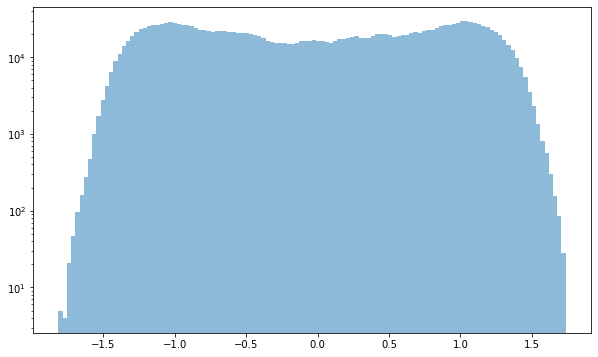

In [8]:
# to see how many datapoints are available within each bin, we create 
# a histogram of the loaded data:

N_hist = N_bins # we use the same number of bins as for the inference
hist, bin_edges = inference.get_histogram(N_hist=N_hist)

bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
bar_width = bin_centers[1] - bin_centers[0]

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.bar(bin_centers,hist,width=bar_width,
      alpha=0.5)
ax.set_yscale('log')
plt.show()
plt.close(fig)

At the domain boundaries, there is less data available. As we will see below, because of this the inferred drift and diffusivity are more noisy there (as compared to regions where a lot of data is available).

# 3. Create and save index

In [9]:
# before running the inference, we need to create and index that stores the information
# which trajectory is in which bin at which time
inference.create_index()

Finished creating index. Processed 4000 trajectories. 


#### Addition to point 3: Load a saved index

Instead of recalculating the index every time an inference is run, the index pertraining to a list of trajectories can be saved and reloaded later. To illustrate this we now save the index, then delete the class instance we worked with so far, and create a new class intance in which we load the index:

In [10]:
inference.save_index()
# this call saves the four files
#   index_bin_indices.pkl
#   index_parameters.pkl
#   index_traj_number.pkl
#   index.pkl
# to the directory given in the string "index_directory"

In [11]:
# delete instance of class
del inference

In [12]:
# create new instance of the class, which needs to know where we store the index files, 
# and where we store the trajectories

parameters = {'index_directory':index_directory,
            'trajectories_filename':trajectories_filename}

inference = fokker_planck.inference.kramers_moyal(parameters=parameters)
inference.load_trajectories()
inference.load_index()

# upon loading the index, all parameters from the previous instance are recovered:
inference.get_parameters()

Loaded 4000 trajectories.


{'trajectories_filename': './sample_trajectories/sample_trajectories.pkl',
 'index_directory': './',
 'xl': -1.8148974043270676,
 'xr': 1.7371557884073707,
 'dx': 0.029600443272786985,
 'dt': 0.0001,
 'N_bins': 120,
 'x': array([-1.80009718, -1.77049674, -1.7408963 , -1.71129585, -1.68169541,
        -1.65209497, -1.62249452, -1.59289408, -1.56329364, -1.53369319,
        -1.50409275, -1.47449231, -1.44489186, -1.41529142, -1.38569098,
        -1.35609053, -1.32649009, -1.29688965, -1.2672892 , -1.23768876,
        -1.20808832, -1.17848787, -1.14888743, -1.11928699, -1.08968654,
        -1.0600861 , -1.03048566, -1.00088521, -0.97128477, -0.94168433,
        -0.91208388, -0.88248344, -0.852883  , -0.82328255, -0.79368211,
        -0.76408167, -0.73448122, -0.70488078, -0.67528034, -0.6456799 ,
        -0.61607945, -0.58647901, -0.55687857, -0.52727812, -0.49767768,
        -0.46807724, -0.43847679, -0.40887635, -0.37927591, -0.34967546,
        -0.32007502, -0.29047458, -0.26087413, -0

# 4. Run inference and plot results

With the trajectories and the index loaded into the class instance, we can finally run the inference:

In [13]:
# if the inference is run without an argument, the value N_shift = 1 is used
inference_result = inference.run_inference() # = inference.run_inference(N_shift=1)

# the call returns a dictionary with the bin centers x, as well as the 
# inferred diffusivity and drift at those bin centers:
x = inference_result['x']
D = inference_result['D']
a = inference_result['a']

Finished inference with 120 bins.                   


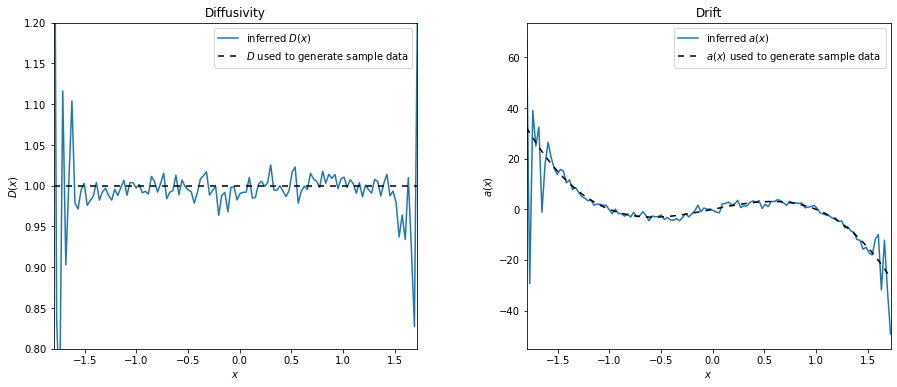

In [14]:
# we plot the results, and compare them to the input D and a(x) used for 
# generating the sample data:

fig,axes = plt.subplots(1,2,figsize=(15,6))
fig.subplots_adjust(wspace=0.3)

ax = axes[0]
ax.set_title('Diffusivity')
ax.plot(x,D,
       label=r'inferred $D(x)$')
ax.axhline(1.,
        dashes=[4,4],
           label='$D$ used to generate sample data',
          color='black')
ax.set_ylim(0.8,1.2)
ax.set_xlim(np.min(x),np.max(x))
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$D(x)$')

ax = axes[1]
ax.set_title('Drift')
ax.plot(x,a,
        label=r'inferred $a(x)$')
ax.plot(x,-4*2*(x**2-1)*x,
        dashes=[4,4],
           label=r'$a(x)$ used to generate sample data',
       color='black')
ax.set_xlim(np.min(x),np.max(x))
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$a(x)$')

plt.show()
plt.close(fig)

Overall, the inference reproduces the parameters used for the sample data generation very well. As expected, the inference is worse where less data is available, i.e. close to the boundaries of the domain.

Finally, we run the inference again for several values for the lagtime, and compare the results:

In [15]:
N_shifts = [1,10,50,100]

inference_results = []

for i,N_shift in enumerate(N_shifts):
    print("Running inference for N_shift = {0}".format(N_shift))
    inference_result = inference.run_inference(N_shift=N_shift)
    inference_results.append(inference_result)

Running inference for N_shift = 1
Finished inference with 120 bins.                   
Running inference for N_shift = 10
Finished inference with 120 bins.                   
Running inference for N_shift = 50
Finished inference with 120 bins.                   
Running inference for N_shift = 100
Finished inference with 120 bins.                   


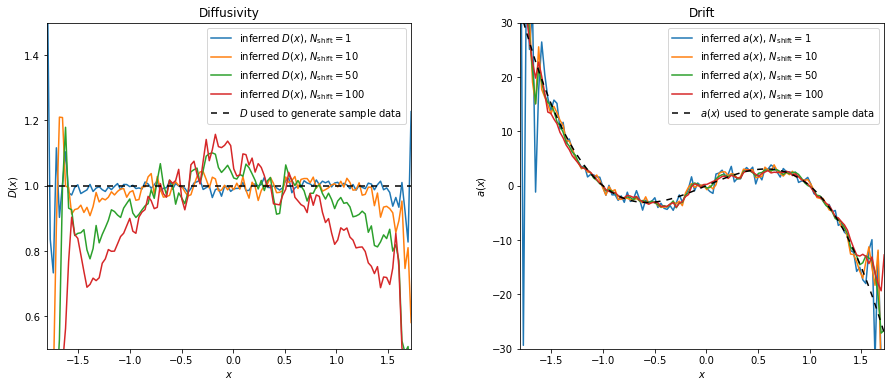

In [16]:
fig,axes = plt.subplots(1,2,figsize=(15,6))
fig.subplots_adjust(wspace=0.3)

for i, inference_result in enumerate(inference_results):
    x = inference_result['x']
    D = inference_result['D']
    a = inference_result['a']
    #
    axes[0].plot(x,D,
       label=r'inferred $D(x)$, $N_{\mathrm{shift}} = $' + '{0}'.format(N_shifts[i]))
    axes[1].plot(x,a,
        label=r'inferred $a(x)$, $N_{\mathrm{shift}} = $' + '{0}'.format(N_shifts[i]))

ax = axes[0]
ax.set_title('Diffusivity')
ax.axhline(1.,
        dashes=[4,4],
           label='$D$ used to generate sample data',
          color='black')
ax.set_ylim(0.5,1.5)
ax.set_xlim(np.min(x),np.max(x))
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$D(x)$')

ax = axes[1]
ax.set_title('Drift')
ax.plot(x,-4*2*(x**2-1)*x,
        dashes=[4,4],
           label=r'$a(x)$ used to generate sample data',
       color='black')
ax.set_ylim(-30,30)
ax.set_xlim(np.min(x),np.max(x))
ax.legend(loc='best')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$a(x)$')

plt.show()
plt.close(fig)

We observe that as the lagtime $N_{\mathrm{shift}}$ is increased, the quality of the diffusivity fit becomes worse. On the other hand, the results for the drift are rather independent of the lagtime.